# Machine learning based predictive modeling of Arabidopsis drought gene expession data

This notebook contains code for predictive modeling of Arabidopsis gene expression data from VanBuren et al. 2024.  This includes filtering the input data, developing random forest based classifiers of drought and control, testing other classifiers, and charactorizing the top predictive features. 

In [1]:
#import packages
import pandas as pd
import seaborn as sns
import numpy as np
import re
import json
import csv
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster import hierarchy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
plt.rcParams['pdf.fonttype'] = 42
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score


Preparing the input data

In [2]:
expr_df = pd.read_csv('Arabidopsis_TPM_8-14-23.tsv', delimiter='\t')
expr_df = expr_df.set_index(expr_df.columns[0])
expr_df.head()

,SRR13134698,SRR13134697,SRR13134696,SRR13134695,SRR13134694,SRR13134693,SRR13134692,SRR13134691,SRR13134690,SRR13134689,...,SRR7217357,SRR7217358,SRR7217361,SRR7217362,SRR7217364,SRR7217365,SRR7217367,SRR7217372,SRR7217373,SRR7217375
GeneID,,,,,,,,,,,,,,,,,,,,,
AT1G01010,6.194397,6.755819,6.240131,11.211688,14.528159,3.364697,11.349768,6.977708,4.879251,3.677041,...,1.314620,0.980246,1.144093,0.224945,0.766847,0.993218,0.688191,0.364360,0.618026,0.620158
AT1G01020,6.313488,5.980893,6.799152,15.006115,13.306829,6.192358,15.266935,8.754127,4.351148,3.461339,...,6.628328,8.727316,8.726632,2.895204,3.319839,5.118361,2.984822,1.740033,2.616836,2.756868
AT1G01030,2.495984,2.453966,2.491543,3.122946,5.199754,3.316352,4.401286,2.549273,3.688480,3.267363,...,0.197505,0.104904,0.393433,0.160918,0.142264,0.115867,0.124270,0.050160,0.034014,0.161809
AT1G01040,15.888175,14.959274,13.426500,15.636013,15.652931,9.677851,16.475769,16.655656,10.282821,8.272203,...,1.863715,1.312444,1.780143,0.860325,0.857214,1.262846,1.640237,1.041538,1.315620,1.218821
AT1G01050,86.296448,76.257584,84.999951,92.253649,71.635072,75.300099,82.279578,83.941553,76.164501,85.124187,...,14.894059,12.494360,15.281672,12.017407,10.660425,13.260913,18.150083,8.724780,11.025545,8.093256


In [3]:
## Filter out non-expressed genes

expr_df = expr_df.loc[expr_df.sum(axis=1) > 10, :]
expr_df.shape

## Filter out lowly expressed genes

mask_low_vals = (expr_df > 1).sum(axis=1) > 10
expr_df = expr_df.loc[mask_low_vals, :]

### Filter out any SRA samples with all 0s

filtered_df = expr_df.loc[:, (expr_df != 0).any(axis=0)]
filtered_df.shape

(24591, 1290)

In [4]:
def log_transform(df):
    log_df = df.copy() # so we don't modify the original dataframe if we didn't want to
    
    # (Lifted from RNAseq_Meta_analysis.ipynb)
    for c in [c for c in log_df.columns if np.issubdtype(log_df[c].dtype , np.number)]:
        log_df[c] += 1
    for c in [c for c in log_df.columns if np.issubdtype(log_df[c].dtype , np.number)]:
        log_df[c] = np.log(log_df[c])
    return log_df

log_expr_df = log_transform(expr_df)
log_expr_df.head()

,SRR13134698,SRR13134697,SRR13134696,SRR13134695,SRR13134694,SRR13134693,SRR13134692,SRR13134691,SRR13134690,SRR13134689,...,SRR7217357,SRR7217358,SRR7217361,SRR7217362,SRR7217364,SRR7217365,SRR7217367,SRR7217372,SRR7217373,SRR7217375
GeneID,,,,,,,,,,,,,,,,,,,,,
AT1G01010,1.973303,2.048443,1.979639,2.502394,2.742655,1.473549,2.513637,2.076651,1.771429,1.542666,...,0.839246,0.683221,0.762717,0.202896,0.569197,0.689750,0.523658,0.310685,0.481207,0.482524
AT1G01020,1.989720,1.943177,2.054015,2.772971,2.660737,1.973019,2.789135,2.277690,1.677311,1.495449,...,2.031869,2.274938,2.274868,1.359746,1.463218,1.811294,1.382493,1.007970,1.285600,1.323586
AT1G01030,1.251615,1.239523,1.250344,1.416568,1.824510,1.462411,1.686637,1.266743,1.545108,1.450996,...,0.180240,0.099758,0.331770,0.149211,0.133012,0.109632,0.117134,0.048943,0.033448,0.149978
AT1G01040,2.826614,2.770040,2.669067,2.811570,2.812586,2.368172,2.860815,2.871056,2.423281,2.227021,...,1.052120,0.838305,1.022502,0.620751,0.619078,0.816623,0.970869,0.713703,0.839677,0.796976
AT1G01050,4.469310,4.347145,4.454347,4.535323,4.285448,4.334674,4.422203,4.441963,4.345940,4.455790,...,2.765945,2.602272,2.790040,2.566287,2.456201,2.657522,2.952307,2.274677,2.487033,2.207533


In [5]:
# Transpose of the data so each row corresponds to an SRA numbers
expr_df_trans = expr_df.transpose()
log_expr_df_trans = log_expr_df.transpose()

log_expr_df_trans.head()


GeneID,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,ATMG01275,ATMG01280,ATMG01290,ATMG01320,ATMG01330,ATMG01350,ATMG01360,ATMG01370,ATMG01400,ATMG01410
SRR13134698,1.973303,1.989720,1.251615,2.826614,4.469310,2.534552,2.442592,3.528407,4.589218,5.798741,...,0.615206,0.362489,0.000000,1.384015,1.735014,0.201441,1.335908,0.456568,0.0,0.0
SRR13134697,2.048443,1.943177,1.239523,2.770040,4.347145,2.626651,1.969062,3.505378,4.534910,6.013694,...,0.999145,0.268239,0.000000,0.000000,0.472994,0.000000,0.935013,1.028488,0.0,0.0
SRR13134696,1.979639,2.054015,1.250344,2.669067,4.454347,2.154850,1.922860,3.489413,4.439072,6.289056,...,0.000000,0.000000,0.387136,0.476009,0.000000,0.000000,0.696638,1.137097,0.0,0.0
SRR13134695,2.502394,2.772971,1.416568,2.811570,4.535323,1.971287,2.480335,3.167088,4.341457,6.193354,...,0.000000,0.236895,0.000000,0.860832,0.233221,0.000000,0.855508,0.310835,0.0,0.0
SRR13134694,2.742655,2.660737,1.824510,2.812586,4.285448,1.874525,1.947453,3.449664,4.343682,6.087006,...,0.000000,0.429225,0.000000,0.501084,1.666563,0.000000,0.813918,0.290220,0.0,0.0


In [6]:
#Import class labels (0=control, 1=drought) and experiments delineated by BioProject.  
ML_labels = pd.read_csv('ML_LOO.txt', delimiter='\t')
ML_labels.head()

,GeneID,Experiment_Type,Class_Label
0,SRR649737,1,0
1,SRR649738,1,0
2,SRR649739,1,1
3,SRR649740,1,1
4,SRR649741,1,0


In [7]:
#log_expr_df_trans.set_index('GeneID', inplace=True)
ML_labels.set_index('GeneID', inplace=True)

In [8]:
merged_df = log_expr_df_trans.merge(ML_labels, left_index=True, right_index=True)

In [9]:
merged_df.shape

(839, 24593)

In [13]:
expr_ML = expr_df_trans.merge(ML_labels, left_index=True, right_index=True)
expr_ML_clean = expr_ML.dropna()
expr_ML_clean.shape

(839, 24593)

In [14]:
expr_ML_clean.head()

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,ATMG01290,ATMG01320,ATMG01330,ATMG01350,ATMG01360,ATMG01370,ATMG01400,ATMG01410,Experiment_Type,Class_Label
SRR13134698,6.194397,6.313488,2.495984,15.888175,86.296448,11.610774,10.502823,33.069647,97.417430,328.883931,...,0.000000,2.990894,4.669010,0.223164,2.803447,0.578647,0.0,0.0,70,1
SRR13134697,6.755819,5.980893,2.453966,14.959274,76.257584,12.827379,6.163950,32.294016,92.215079,407.991459,...,0.000000,0.000000,0.604792,0.000000,1.547247,1.796834,0.0,0.0,70,1
SRR13134696,6.240131,6.799152,2.491543,13.426500,84.999951,7.626595,5.840497,31.766713,83.696316,537.644707,...,0.472757,0.609637,0.000000,0.000000,1.006993,2.117704,0.0,0.0,70,1
SRR13134695,11.211688,15.006115,3.122946,15.636013,92.253649,6.179914,10.945269,22.738253,75.819350,488.485275,...,0.000000,1.365127,0.262661,0.000000,1.352570,0.364564,0.0,0.0,70,0
SRR13134694,14.528159,13.306829,5.199754,15.652931,71.635072,5.517723,6.010811,30.489823,75.990483,439.101978,...,0.000000,0.650509,4.293939,0.000000,1.256733,0.336721,0.0,0.0,70,0


Random Forest based classifier using 75% of the BioProjects for training and 25% for testing. 

#### LOO
Now, let's apply a leave one out approach, where a classifier is trained using all but one dataset and the performance is calculated iteratively for each BioProject. This script will output the precision, accuracy, and recall for each dataset to provide a rough proxy of dataset quality. 

In [15]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Separate features (gene expression values) and target (class labels)
X = expr_ML_clean.iloc[:, 1:-2]
y = expr_ML_clean.iloc[:, -1].astype(int)

# Assuming that the 'Experiment_Type' or some similar column indicates the experiment id
experiment_ids = expr_ML_clean['Experiment_Type'].unique()

scores = []
reports = []

# For each unique experiment id
for exp_id in experiment_ids:
    train_data = expr_ML_clean[expr_ML_clean['Experiment_Type'] != exp_id]
    test_data = expr_ML_clean[expr_ML_clean['Experiment_Type'] == exp_id]
    
    # Separate features and targets for training and testing data
    X_train = train_data.iloc[:, 1:-2]
    y_train = train_data.iloc[:, -1].astype(int)
    X_test = test_data.iloc[:, 1:-2]
    y_test = test_data.iloc[:, -1].astype(int)
    
    # Create and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf_classifier.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Store the accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    
    scores.append(accuracy)
    reports.append(report)

    # Print individual experiment performance
    print(f"Experiment {exp_id}: Accuracy = {accuracy:.2f}")
    print(f"Classification Report for Experiment {exp_id}:")
    for label, metrics in report.items():
        if label != 'accuracy':
            print(f"  {label}: Precision = {metrics['precision']:.2f}, Recall = {metrics['recall']:.2f}, F1-score = {metrics['f1-score']:.2f}")
    print("-" * 50)
    
# Train RandomForest on all data to get the overall feature importances
rf_classifier_all = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_classifier_all.fit(X, y)

# Get feature importances
feature_importances = rf_classifier_all.feature_importances_

# Pair each feature name with its importance score
features_list = X.columns
feature_importance_pairs = list(zip(features_list, feature_importances))

# Sort features based on importance
sorted_feature_importance = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Create DataFrame for top N features
N = 1000
top_features_df = pd.DataFrame(sorted_feature_importance[:N], columns=['Feature', 'Importance'])

print(top_features_df)    
    # Average accuracy and classification report
mean_accuracy = sum(scores) / len(scores)
print("Average Accuracy:", mean_accuracy)

# Averaging classification report might be more involved depending on what metrics you want
# For now, we'll just demonstrate averaging precision, recall, and f1-score for each class
avg_report = {label: {'precision': 0, 'recall': 0, 'f1-score': 0} for label in reports[0].keys() if label != 'accuracy'}
for report in reports:
    for label, metrics in report.items():
        if label != 'accuracy':
            avg_report[label]['precision'] += metrics['precision']
            avg_report[label]['recall'] += metrics['recall']
            avg_report[label]['f1-score'] += metrics['f1-score']

for label, metrics in avg_report.items():
    avg_report[label]['precision'] /= len(reports)
    avg_report[label]['recall'] /= len(reports)
    avg_report[label]['f1-score'] /= len(reports)

print("Average Classification Report:", avg_report)

Experiment 70: Accuracy = 0.45
Classification Report for Experiment 70:
  0: Precision = 1.00, Recall = 0.00, F1-score = 0.00
  1: Precision = 0.45, Recall = 1.00, F1-score = 0.62
  macro avg: Precision = 0.73, Recall = 0.50, F1-score = 0.31
  weighted avg: Precision = 0.75, Recall = 0.45, F1-score = 0.28
--------------------------------------------------
Experiment 69: Accuracy = 0.87
Classification Report for Experiment 69:
  0: Precision = 0.80, Recall = 1.00, F1-score = 0.89
  1: Precision = 1.00, Recall = 0.73, F1-score = 0.84
  macro avg: Precision = 0.90, Recall = 0.86, F1-score = 0.87
  weighted avg: Precision = 0.90, Recall = 0.87, F1-score = 0.87
--------------------------------------------------
Experiment 20: Accuracy = 0.71
Classification Report for Experiment 20:
  0: Precision = 0.75, Recall = 0.75, F1-score = 0.75
  1: Precision = 0.67, Recall = 0.67, F1-score = 0.67
  macro avg: Precision = 0.71, Recall = 0.71, F1-score = 0.71
  weighted avg: Precision = 0.71, Recall =

Experiment 14: Accuracy = 0.55
Classification Report for Experiment 14:
  0: Precision = 1.00, Recall = 0.00, F1-score = 0.00
  1: Precision = 0.55, Recall = 1.00, F1-score = 0.71
  macro avg: Precision = 0.77, Recall = 0.50, F1-score = 0.35
  weighted avg: Precision = 0.75, Recall = 0.55, F1-score = 0.39
--------------------------------------------------
Experiment 11: Accuracy = 0.50
Classification Report for Experiment 11:
  0: Precision = 0.50, Recall = 1.00, F1-score = 0.67
  1: Precision = 1.00, Recall = 0.00, F1-score = 0.00
  macro avg: Precision = 0.75, Recall = 0.50, F1-score = 0.33
  weighted avg: Precision = 0.75, Recall = 0.50, F1-score = 0.33
--------------------------------------------------
Experiment 73: Accuracy = 0.78
Classification Report for Experiment 73:
  0: Precision = 1.00, Recall = 0.67, F1-score = 0.80
  1: Precision = 0.60, Recall = 1.00, F1-score = 0.75
  macro avg: Precision = 0.80, Recall = 0.83, F1-score = 0.77
  weighted avg: Precision = 0.87, Recall =

#### Plot the accuracy for each experiment

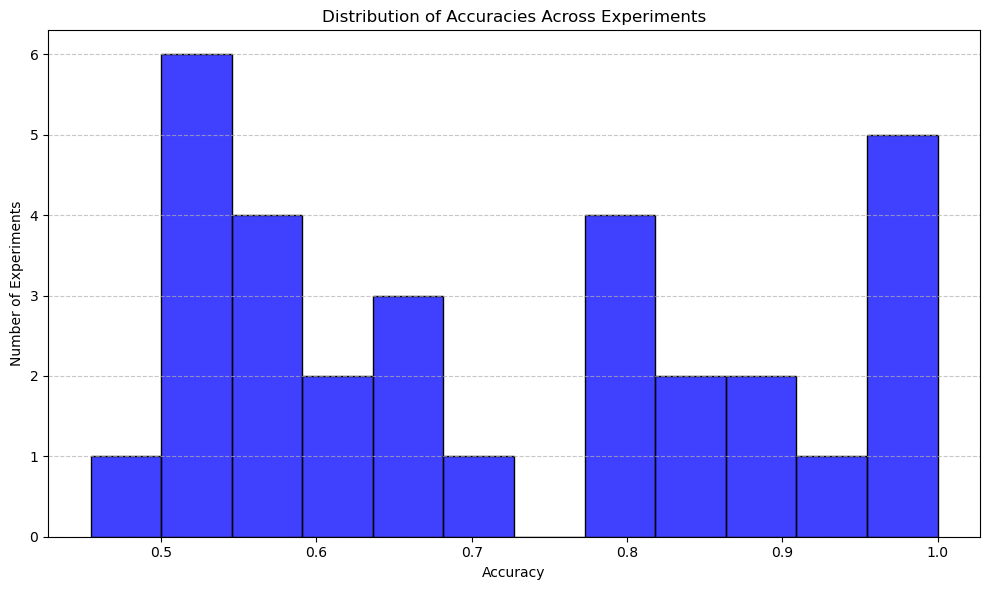

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your plot code
plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=12, kde=False, color='blue')  # You can adjust 'bins' as needed
plt.xlabel('Accuracy')
plt.ylabel('Number of Experiments')
plt.title('Distribution of Accuracies Across Experiments')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Saving the plot as a PDF
plt.savefig("ExperimentAccuracy.pdf")
plt.show()  # If you want to also display the plot


Let's look at the top features (genes) in our predictive models

In [17]:
top_features_df.to_csv('top_features.csv', index=False)

In [18]:
# Get the top 100 feature names
top_100_features = [feature[0] for feature in sorted_feature_importance[:1000]]

# Extract only the top 100 features, along with 'Experiment_Type' and 'Class'
selected_columns = top_100_features + ['Experiment_Type', 'Class_Label']
sub_df = expr_ML_clean[selected_columns]
sub_df[top_100_features] = np.log2(sub_df[top_100_features] + 1)


C:\Users\bobva\AppData\Local\Temp\ipykernel_8364\2626640335.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df[top_100_features] = np.log2(sub_df[top_100_features] + 1)


In [19]:
sorted_sub_df.head

NameError: name 'sorted_sub_df' is not defined

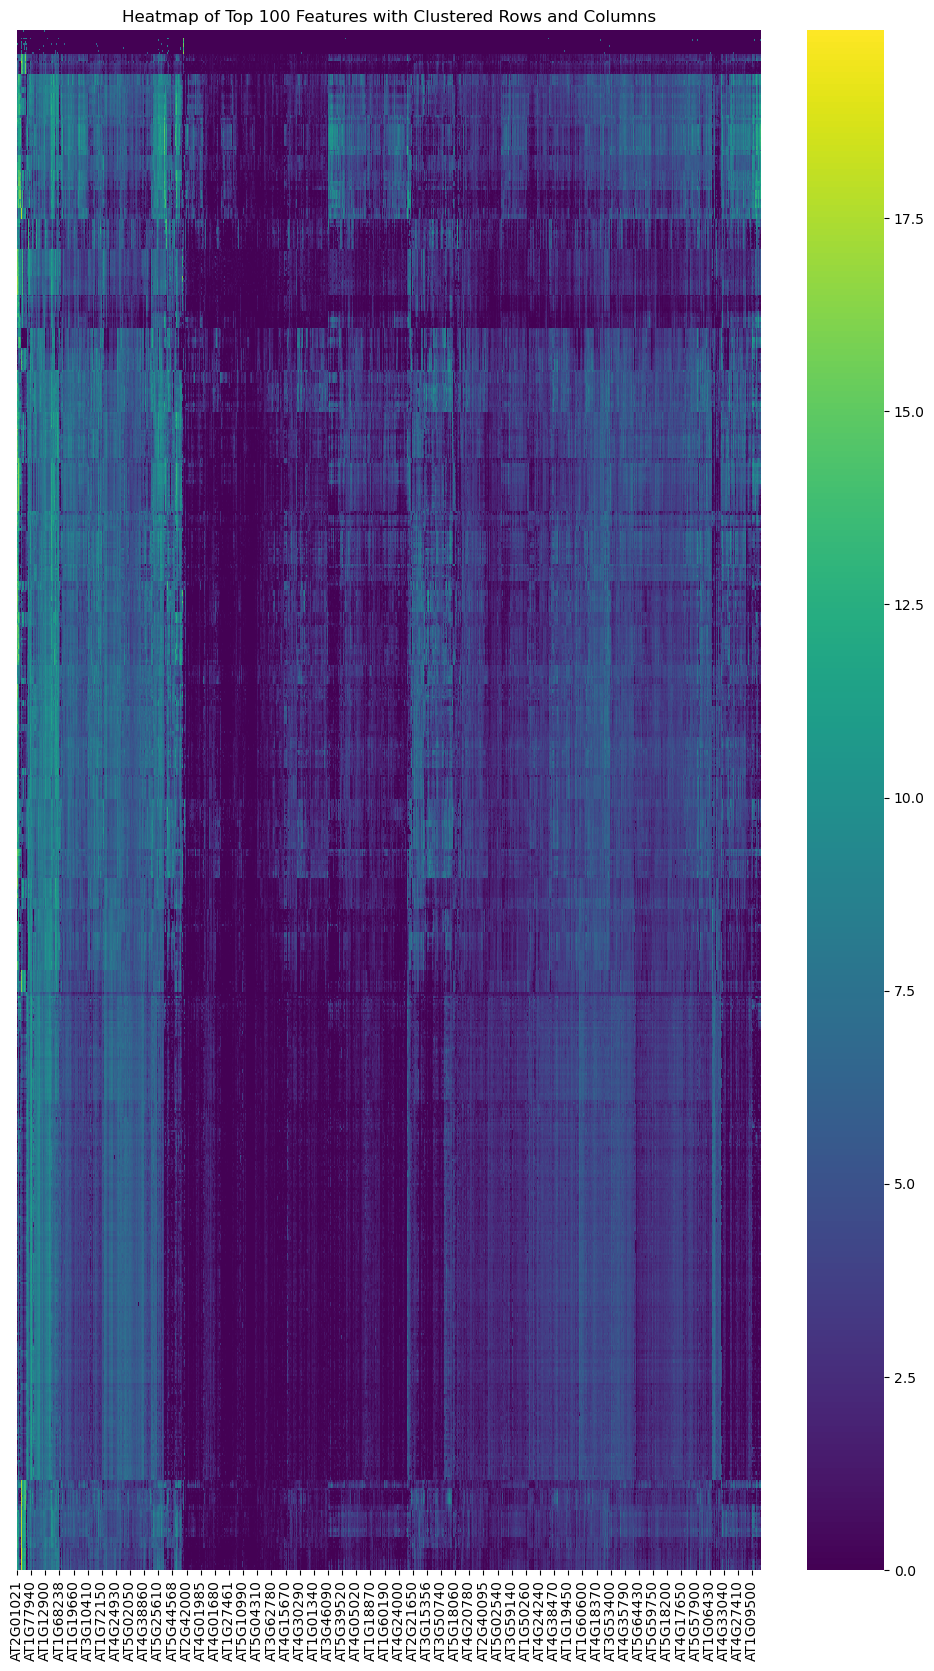

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

# Assuming sub_df is defined somewhere above in your code

# Drop Experiment_Type and class for plotting
plot_df = sub_df.drop(columns=['Experiment_Type', 'Class_Label'])

# Compute the linkage matrix for the columns of the data (transpose the DataFrame for columns)
col_link = linkage(plot_df.T, method='average')

# Compute the linkage matrix for the rows
row_link = linkage(plot_df, method='average')

# Get the order of columns and rows based on clustering
col_order = leaves_list(col_link)
row_order = leaves_list(row_link)

# Reorder rows and columns based on the clustering order
reordered_df = plot_df.iloc[row_order, col_order]

# Create the heatmap
plt.figure(figsize=(12, 20))  # Adjust size as needed
sns.heatmap(reordered_df, cmap='viridis', yticklabels=False)

# Add title and show plot
plt.title('Heatmap of Top 100 Features with Clustered Rows and Columns')
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


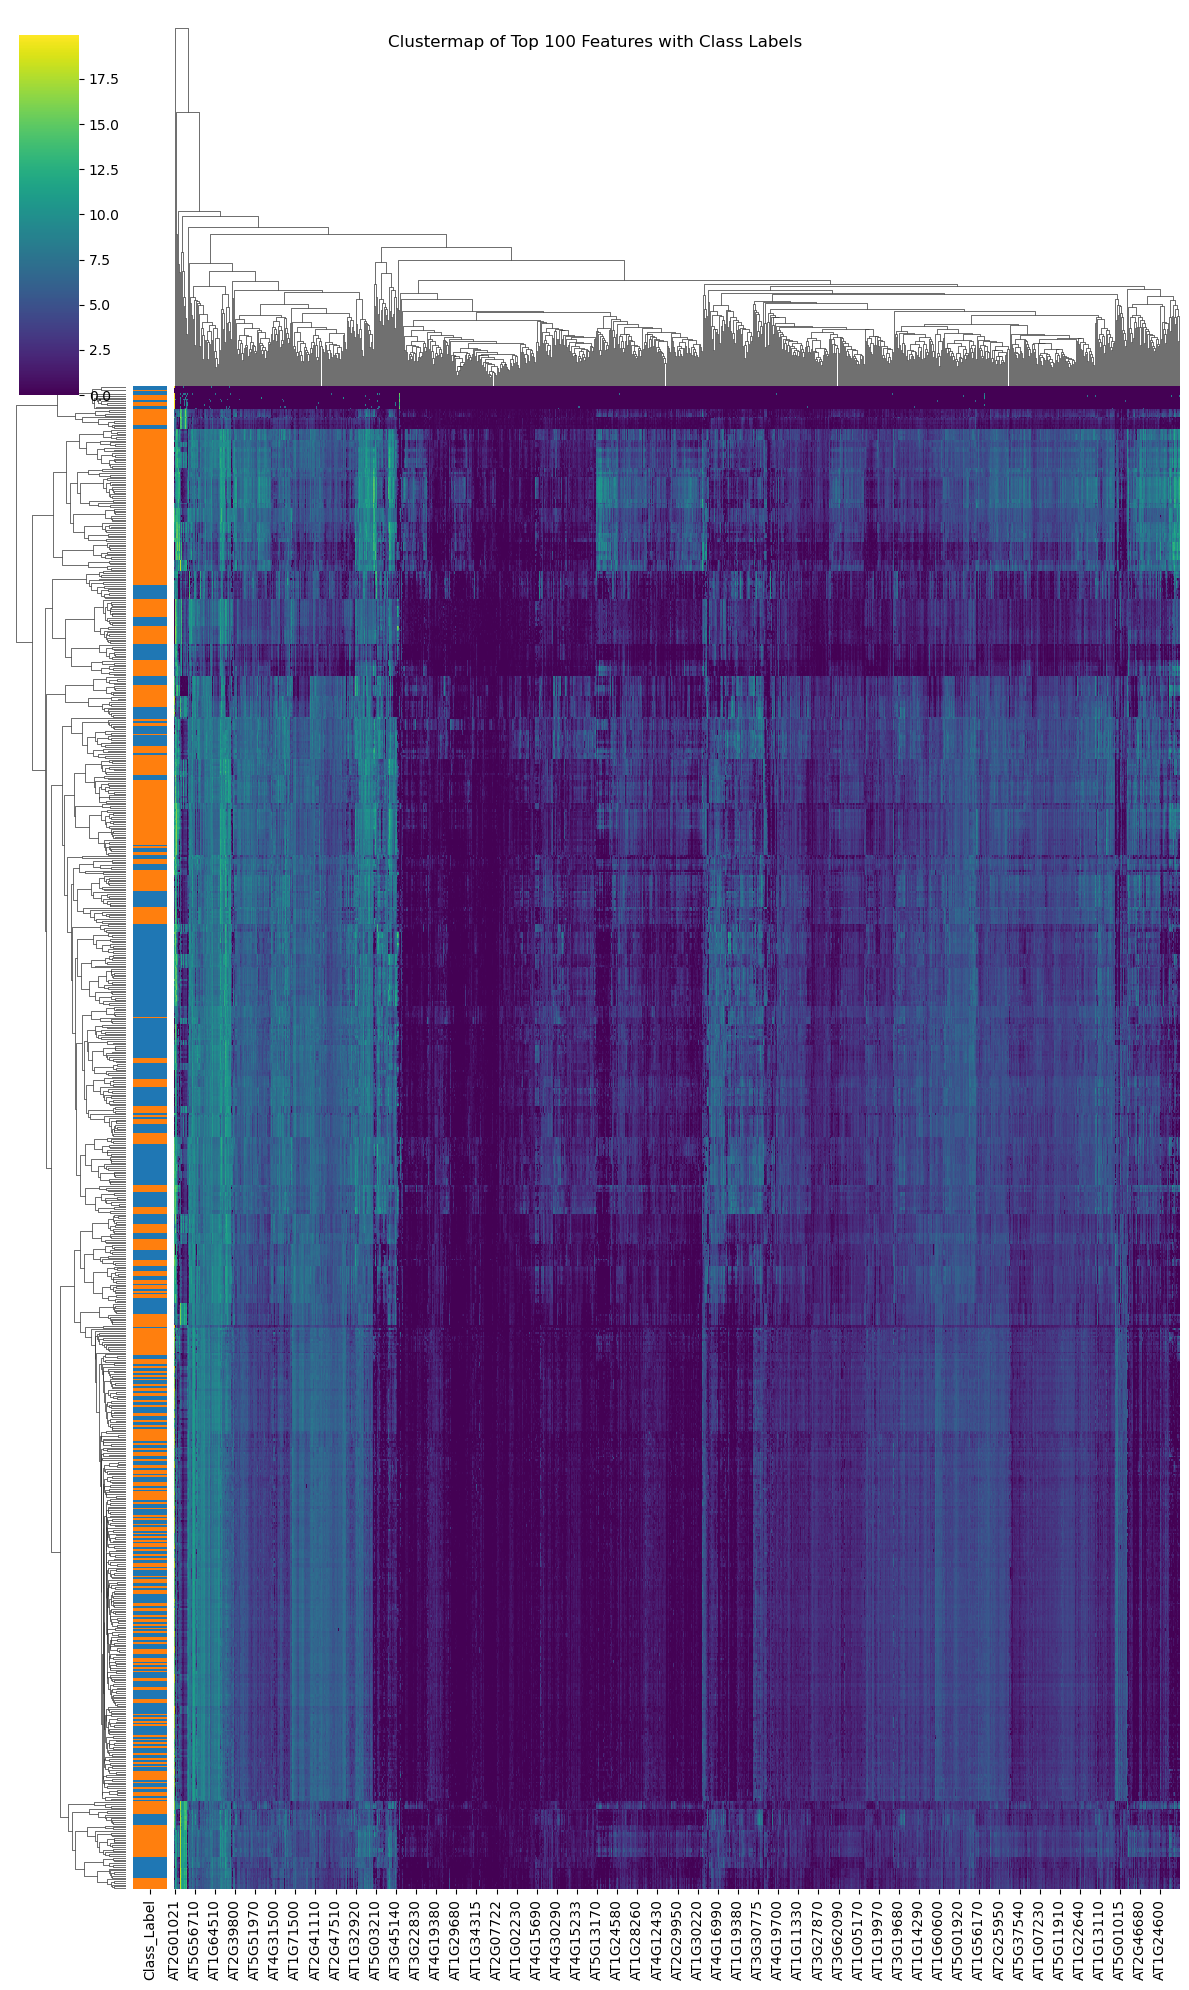

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming sub_df is defined somewhere above in your code

# Drop Experiment_Type for plotting, but keep Class_Label for hue
plot_df = sub_df.drop(columns=['Experiment_Type'])

# Create a palette based on unique class labels
palette = sns.color_palette('tab10', n_colors=plot_df['Class_Label'].nunique())

# Map each class label to a color
row_colors = plot_df['Class_Label'].map(lambda x: palette[int(x)])

# Create the clustermap
sns.clustermap(
    plot_df.drop(columns='Class_Label'), 
    cmap='viridis', 
    yticklabels=False, 
    row_cluster=True, 
    col_cluster=True,
    figsize=(12, 20),  # Adjust size as needed
    row_colors=row_colors,
    dendrogram_ratio=(.1, .2)
)

# Add title
plt.suptitle('Clustermap of Top 100 Features with Class Labels')

plt.savefig("heatmap.pdf")
plt.show()  # If you want to also display the plot

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Separate features (gene expression values) and target (class labels)
X = expr_ML_clean.iloc[:, 1:-2]  # Assuming the last two columns are 'Experiment_Type' and 'Class_Label'
y = expr_ML_clean.iloc[:, -1].astype(int)  # Class labels

# Get the unique experiment types from the 'Experiment_Type' column
unique_experiment_types = expr_ML_clean['Experiment_Type'].unique()

# Shuffle the experiment types randomly
import numpy as np
np.random.seed(42)  # For reproducibility
np.random.shuffle(unique_experiment_types)

# Calculate the index to split the experiment types into training and testing (75% - 25%)
split_idx = int(0.75 * len(unique_experiment_types))
train_experiment_types = unique_experiment_types[:split_idx]
test_experiment_types = unique_experiment_types[split_idx:]

# Filter the DataFrame to get training and testing data separately
train_data = expr_ML_clean[expr_ML_clean['Experiment_Type'].isin(train_experiment_types)]
test_data = expr_ML_clean[expr_ML_clean['Experiment_Type'].isin(test_experiment_types)]

# Separate features and target for training and testing data
X_train = train_data.iloc[:, 1:-2]
y_train = train_data.iloc[:, -1].astype(int)
X_test = test_data.iloc[:, 1:-2]
y_test = test_data.iloc[:, -1].astype(int)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

# Create a base model
rf = RandomForestClassifier(random_state=42)

# Use the random grid to search for best hyperparameters
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", rf_random.best_params_)

# Make predictions on the testing set using the best model
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 20}
Accuracy: 0.6629526462395543
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.84      0.70       167
           1       0.79      0.51      0.62       192

    accuracy                           0.66       359
   macro avg       0.69      0.67      0.66       359
weighted avg       0.70      0.66      0.65       359



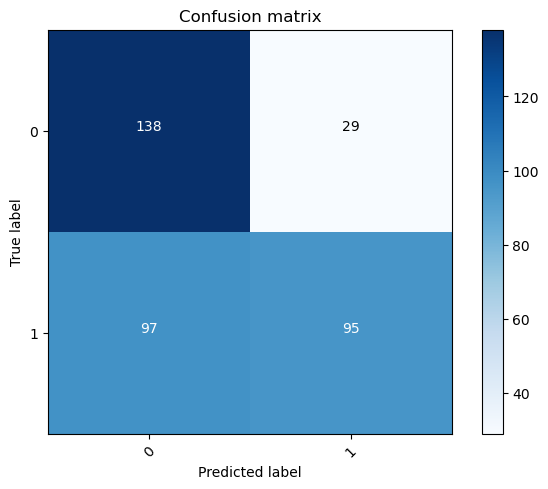

In [34]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define a custom function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=[0, 1])
plt.savefig('confusion_matrix.pdf')
plt.show()

## Testing if downsampling improves prediction
Generally, researchers collect more drought samples than control, and this class imbalance could lead to poor performance of the ML classification algorithm. We downsampled the drought timepoints to see if this affected performance.

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Assuming expr_ML_clean is your dataframe and the last column contains the target labels
class_counts = expr_ML_clean.iloc[:, -1].value_counts()

# Display the class counts
print(class_counts)

# Find the class name of the minority class and the number of samples in it
minority_class = class_counts.idxmin()
minority_count = class_counts.min()

# Downsample the majority classes
downsampled_dataframes = []

for class_label, count in class_counts.iteritems():
    class_samples = expr_ML_clean[expr_ML_clean.iloc[:, -1] == class_label]
    
    if class_label == minority_class:
        downsampled_dataframes.append(class_samples)
    else:
        downsampled_class_samples = resample(class_samples, 
                                             replace=False, # do not sample with replacement
                                             n_samples=minority_count, # match minority count
                                             random_state=42) # reproducible results

        downsampled_dataframes.append(downsampled_class_samples)

# Combine minority and downsampled majority dataframes
downsampled_data = pd.concat(downsampled_dataframes)

# Verify if classes have been balanced
print(downsampled_data.iloc[:, -1].value_counts())

In [ ]:
# Separate features (gene expression values) and target (class labels)
X = downsampled_data.iloc[:, 1:-1]  # Gene expression values
y = downsampled_data.iloc[:, -1].astype(int)    # Class labels

# Split the data into training (75%) and testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=5000, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Testing other classifiers for their performance 
We will also test the following classifiers. Based on our previous work (See Pardo et al. 2023, PNAS), Random Forest works best using high dimensional gene expression datasets. Each classifier has strengths/weaknesses, and I have included some notes below. I have tried some hyperparameterization, but of course, each of these could be refined to produce better results. 

**KNeighborsClassifier (K-Nearest Neighbors, KNN):**

**Description:** KNN is a simple, instance-based learning algorithm. It classifies a new sample based on the majority class of its 'k' nearest neighbors in the training set. The number of neighbors (k) and the method of measuring distance (Euclidean, Manhattan, etc.) are key parameters.

**Characteristics:** Non-parametric, good for smaller datasets, sensitive to the scale of features, and requires no training phase but can be computationally expensive during prediction.

**LinearSVC (Linear Support Vector Classifier):**

**Description:** LinearSVC is a linear model for classification that separates data points using a hyperplane with the maximum margin. It's effective in high-dimensional spaces and particularly suited for binary classification.

**Characteristics:** Good for both sparse and dense data, scales well to large numbers of samples, involves a regularization parameter C, and is less prone to overfitting.

**MLPClassifier (Multi-Layer Perceptron):**

**Description:** MLPClassifier is a neural network model for classification. It consists of multiple layers of nodes, each layer fully connected to the next one. It uses backpropagation for training.

**Characteristics:** Can model complex non-linear relationships, highly flexible due to different architectures, prone to overfitting on small datasets, and requires more data to perform well.

**HistGradientBoostingClassifier:**

**Description:** This classifier is a gradient boosting model for classification. It builds an additive model in a forward stage-wise fashion and it generalizes decision trees by allowing optimization of arbitrary differentiable loss functions.

**Characteristics:** Efficient for large datasets, handles categorical features natively, robust to outliers and different scales of features, and often provides high predictive accuracy.


In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Separate features (gene expression values) and target (class labels)
X = expr_ML_clean.iloc[:, 1:-2]  # Assuming the last two columns are 'Experiment_Type' and 'Class_Label'
y = expr_ML_clean.iloc[:, -1].astype(int)  # Class labels

# Get the unique experiment types from the 'Experiment_Type' column
unique_experiment_types = expr_ML_clean['Experiment_Type'].unique()

# Shuffle the experiment types randomly

np.random.seed(42)  # For reproducibility
np.random.shuffle(unique_experiment_types)

# Calculate the index to split the experiment types into training and testing (75% - 25%)
split_idx = int(0.75 * len(unique_experiment_types))
train_experiment_types = unique_experiment_types[:split_idx]
test_experiment_types = unique_experiment_types[split_idx:]

# Filter the DataFrame to get training and testing data separately
train_data = expr_ML_clean[expr_ML_clean['Experiment_Type'].isin(train_experiment_types)]
test_data = expr_ML_clean[expr_ML_clean['Experiment_Type'].isin(test_experiment_types)]

# Separate features and target for training and testing data
X_train = train_data.iloc[:, 1:-2]
y_train = train_data.iloc[:, -1].astype(int)
X_test = test_data.iloc[:, 1:-2]
y_test = test_data.iloc[:, -1].astype(int)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
X_train_scaled = scaler.fit_transform(X_train)

# Apply transform to both the training set and the test set
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],  # different values for number of neighbors
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # different distance metrics
    'weights': ['uniform', 'distance']  # weighting type
}

# Create a base KNN model
knn = KNeighborsClassifier()

# Random search of parameters
knn_random = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, 
                                n_iter=42, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model on the scaled training data
knn_random.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best parameters found: ", knn_random.best_params_)

# Make predictions on the scaled testing set using the best model
best_knn = knn_random.best_estimator_
y_pred = best_knn.predict(X_test_scaled)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 42 candidates, totalling 126 fits
Best parameters found:  {'weights': 'uniform', 'n_neighbors': 11, 'metric': 'manhattan'}
Accuracy: 0.5153203342618384
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.88      0.63       167
           1       0.66      0.20      0.30       192

    accuracy                           0.52       359
   macro avg       0.57      0.54      0.47       359
weighted avg       0.58      0.52      0.45       359



In [31]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Separate features (gene expression values) and target (class labels)
X = expr_ML_clean.iloc[:, 1:-2]  # Assuming the last two columns are 'Experiment_Type' and 'Class_Label'
y = expr_ML_clean.iloc[:, -1].astype(int)  # Class labels

# Get the unique experiment types from the 'Experiment_Type' column
unique_experiment_types = expr_ML_clean['Experiment_Type'].unique()

# Shuffle the experiment types randomly

np.random.seed(42)  # For reproducibility
np.random.shuffle(unique_experiment_types)

# Calculate the index to split the experiment types into training and testing (75% - 25%)
split_idx = int(0.75 * len(unique_experiment_types))
train_experiment_types = unique_experiment_types[:split_idx]
test_experiment_types = unique_experiment_types[split_idx:]

# Filter the DataFrame to get training and testing data separately
train_data = expr_ML_clean[expr_ML_clean['Experiment_Type'].isin(train_experiment_types)]
test_data = expr_ML_clean[expr_ML_clean['Experiment_Type'].isin(test_experiment_types)]

# Separate features and target for training and testing data
X_train = train_data.iloc[:, 1:-2]
y_train = train_data.iloc[:, -1].astype(int)
X_test = test_data.iloc[:, 1:-2]
y_test = test_data.iloc[:, -1].astype(int)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only and transform both training and test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Linear SVC model
svc = LinearSVC(random_state=42)

# Fit the model on the scaled training data
svc.fit(X_train_scaled, y_train)

# Make predictions on the scaled testing set
y_pred = svc.predict(X_test_scaled)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.520891364902507
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.93      0.64       167
           1       0.74      0.16      0.26       192

    accuracy                           0.52       359
   macro avg       0.62      0.55      0.45       359
weighted avg       0.62      0.52      0.44       359



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Separate features (gene expression values) and target (class labels)
X = expr_ML_clean.iloc[:, 1:-2]  # Assuming the last two columns are 'Experiment_Type' and 'Class_Label'
y = expr_ML_clean.iloc[:, -1].astype(int)  # Class labels

# Get the unique experiment types from the 'Experiment_Type' column
unique_experiment_types = expr_ML_clean['Experiment_Type'].unique()

# Shuffle the experiment types randomly

np.random.seed(42)  # For reproducibility
np.random.shuffle(unique_experiment_types)

# Calculate the index to split the experiment types into training and testing (75% - 25%)
split_idx = int(0.75 * len(unique_experiment_types))
train_experiment_types = unique_experiment_types[:split_idx]
test_experiment_types = unique_experiment_types[split_idx:]

# Filter the DataFrame to get training and testing data separately
train_data = expr_ML_clean[expr_ML_clean['Experiment_Type'].isin(train_experiment_types)]
test_data = expr_ML_clean[expr_ML_clean['Experiment_Type'].isin(test_experiment_types)]

# Separate features and target for training and testing data
X_train = train_data.iloc[:, 1:-2]
y_train = train_data.iloc[:, -1].astype(int)
X_test = test_data.iloc[:, 1:-2]
y_test = test_data.iloc[:, -1].astype(int)


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only and transform both training and test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an MLPClassifier model
# Example: 2 hidden layers with 100 neurons each and relu activation
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', random_state=42)

# Fit the model on the scaled training data
mlp.fit(X_train_scaled, y_train)

# Make predictions on the scaled testing set
y_pred = mlp.predict(X_test_scaled)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5654596100278552
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.96      0.67       167
           1       0.86      0.22      0.36       192

    accuracy                           0.57       359
   macro avg       0.69      0.59      0.51       359
weighted avg       0.70      0.57      0.50       359



In [33]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Separate features (gene expression values) and target (class labels)
X = expr_ML_clean.iloc[:, 1:-2]  # Assuming the last two columns are 'Experiment_Type' and 'Class_Label'
y = expr_ML_clean.iloc[:, -1].astype(int)  # Class labels

# Get the unique experiment types from the 'Experiment_Type' column
unique_experiment_types = expr_ML_clean['Experiment_Type'].unique()

# Shuffle the experiment types randomly

np.random.seed(42)  # For reproducibility
np.random.shuffle(unique_experiment_types)

# Calculate the index to split the experiment types into training and testing (75% - 25%)
split_idx = int(0.75 * len(unique_experiment_types))
train_experiment_types = unique_experiment_types[:split_idx]
test_experiment_types = unique_experiment_types[split_idx:]

# Filter the DataFrame to get training and testing data separately
train_data = expr_ML_clean[expr_ML_clean['Experiment_Type'].isin(train_experiment_types)]
test_data = expr_ML_clean[expr_ML_clean['Experiment_Type'].isin(test_experiment_types)]

# Separate features and target for training and testing data
X_train = train_data.iloc[:, 1:-2]
y_train = train_data.iloc[:, -1].astype(int)
X_test = test_data.iloc[:, 1:-2]
y_test = test_data.iloc[:, -1].astype(int)

# Create a HistGradientBoostingClassifier model
# Using default parameters initially; can be tuned later
hist_gradient_boost = HistGradientBoostingClassifier(random_state=42)

# Fit the model on the training data
# No need to scale features for HistGradientBoostingClassifier
hist_gradient_boost.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = hist_gradient_boost.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.649025069637883
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.83      0.69       167
           1       0.77      0.49      0.60       192

    accuracy                           0.65       359
   macro avg       0.68      0.66      0.64       359
weighted avg       0.68      0.65      0.64       359



### Identifying misclassified samples

In [35]:
# Identify the misclassified samples
misclassified_index = y_test != y_pred

# Create a new DataFrame with misclassified samples, true labels, and predicted labels
misclassified_samples = X_test[misclassified_index].copy()
misclassified_samples['true_label'] = y_test[misclassified_index]
misclassified_samples['predicted_label'] = y_pred[misclassified_index]

print("\nMisclassified samples DataFrame:")
print(misclassified_samples.head())


Misclassified samples DataFrame:
             AT1G01020  AT1G01030  AT1G01040  AT1G01050  AT1G01060  AT1G01070  \
ERR754084    50.517772   5.439749   6.120819  75.016684  23.747876   1.794757   
SRR13134705   7.542964   3.234522  11.159070  72.875446  15.468860  14.164530   
SRR12687364  26.877199   0.249576   6.598847  82.034963   0.530283   0.218156   
SRR1848798    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
ERR1588945   42.033240   4.592578   4.194988  53.976110   9.365375   0.000000   

              AT1G01080   AT1G01090    AT1G01100  AT1G01110  ...  ATMG01290  \
ERR754084    112.245626  159.804377  1616.424990   1.919557  ...        0.0   
SRR13134705   26.595405  175.538019   394.945074   2.506477  ...        0.0   
SRR12687364  150.393789   96.430765   415.377067   1.009177  ...        0.0   
SRR1848798     0.000000    0.000000     0.000000   0.000000  ...        0.0   
ERR1588945    63.103204   99.300452  2674.549790   3.257613  ...        0.0   

    

In [37]:
# Save the misclassified_samples DataFrame to a TSV file
misclassified_samples.to_csv('misclassified_samples.tsv', sep='\t', index=True)